# Environment Setup & Imports

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

**Neccesary Imports**

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


from torch.utils.data import DataLoader, Dataset
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import argparse
import copy

import time
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')  
else:
    device = torch.device('cpu')

print(f"Selected device: {device}")

Selected device: cuda


**Unzip file (RUN ONCE)**

In [ ]:
!unzip "/content/drive/MyDrive/prime_data/Prime_FULL.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Prime_FULL/02-043/W52/OS/42.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/43.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/44.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/45.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/46.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/47.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/48.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/5.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/6.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/7.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/8.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/9.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/fundus_OS_W52.tif  
  inflating: /content/Prime_FULL/02-043/W52/OS/fundus_W52.tif  
   creating: /content/Prime_FULL/02-043/W60/
   creating: /content/Prime_FULL/02-043/W60/OD/
  inflating: /content/Prime_FULL/02-043/W60/OD/33.tif  
  

In [ ]:
!cp "/content/drive/MyDrive/prime_data/df_prime_train.csv" -d "/content/"
!cp "/content/drive/MyDrive/prime_data/df_prime_test.csv" -d "/content/"

# Load Data

**Image Data Declaration**

In [ ]:
from skimage import exposure
from skimage.filters import median
from skimage.color import rgb2gray
from PIL import ImageOps


# Labels for Severity
LABELS_Severity = {35: 0,
                   43: 0,
                   47: 1,
                   53: 1,
                   61: 2,
                   65: 2,
                   71: 2,
                   85: 2}


mean = (.1706)
std = (.2112)
normalize = transforms.Normalize(mean=mean, std=std)

transform = transforms.Compose([
    transforms.CenterCrop(size=(299,299)),
    transforms.ToTensor(),
    normalize,
])

    
class OCTDataset(Dataset):
    def __init__(self, args, subset='train', transform=None,):
        if subset == 'train':
            self.annot = pd.read_csv(args.annot_train_prime, nrows=1792) #24064
        elif subset == 'test':
            self.annot = pd.read_csv(args.annot_test_prime, nrows=768) #7936
            
        self.annot['Severity_Label'] = [LABELS_Severity[drss] for drss in copy.deepcopy(self.annot['DRSS'].values)] 
        # print(self.annot)
        self.root = os.path.expanduser(args.data_root)
        self.transform = transform
        # self.subset = subset
        self.nb_classes=len(np.unique(list(LABELS_Severity.values())))
        self.path_list = self.annot['File_Path'].values
        self._labels = self.annot['Severity_Label'].values
        assert len(self.path_list) == len(self._labels)
        # idx_each_class = [[] for i in range(self.nb_classes)]

    def __getitem__(self, index):
        img, target = Image.open(self.root+self.path_list[index]).convert("L"), self._labels[index]

        img = transforms.Grayscale(num_output_channels=3)(img)

        if self.transform is not None:
            img = self.transform(img)
        return img, target


    def __len__(self):
        return len(self._labels)         

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--annot_train_prime', type = str, default = 'df_prime_train.csv')
    parser.add_argument('--annot_test_prime', type = str, default = 'df_prime_test.csv')
    parser.add_argument('--data_root', type = str, default = '/content/')
    parser.add_argument('-f') #For ipynb support
    return parser.parse_args()


if __name__ == '__main__':
    args = parse_args()
    trainset = OCTDataset(args, 'train', transform=transform)
    testset = OCTDataset(args, 'test', transform=transform)
    print("Train Set Array Size:", trainset[1][0].shape)
    print("Size of trainset: " + str(len(trainset)) + "\nSize of testset:", len(testset))


Train Set Array Size: torch.Size([3, 299, 299])
Size of trainset: 1792
Size of testset: 768


**Split Training/Validation/Test Data**

In [ ]:
batcheSize = 256

trainloader = DataLoader(trainset, batch_size= batcheSize, shuffle=True)
testloader =  DataLoader(testset, batch_size=batcheSize, shuffle=True)

print("Size of trainloader: " + str(len(trainloader)) + "\nSize of testloader:", len(testloader))
print(f"Number of images in trainloader: {len(trainloader) * batcheSize}")
print(f"Number of images in testloader: {len(testloader) * batcheSize}")


Size of trainloader: 7
Size of testloader: 3
Number of images in trainloader: 1792
Number of images in testloader: 768


**View 5 random sample images**

(496, 504)
(496, 504)
(496, 504)
(496, 504)
(496, 504)


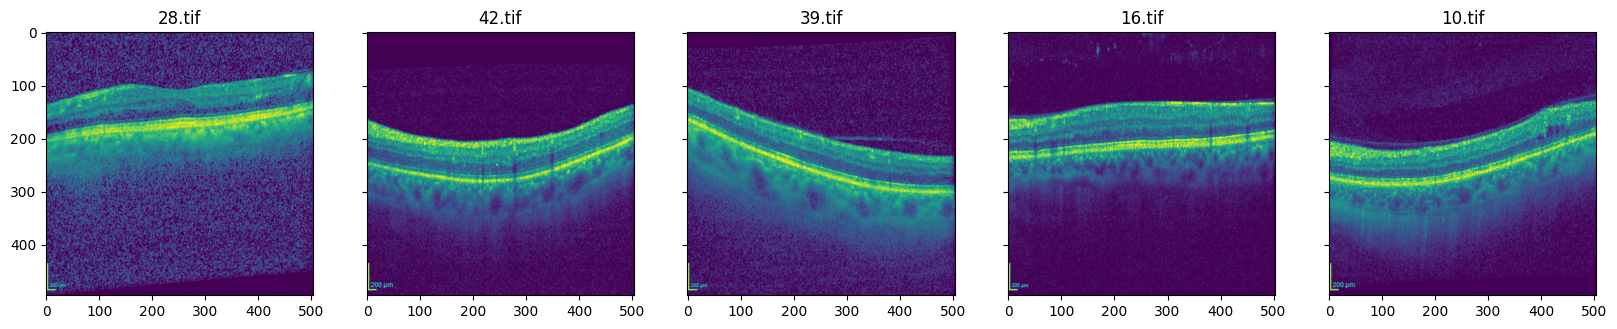

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# load the csv file
df = pd.read_csv('/content/df_prime_train.csv')

# shuffle the rows and select the first 5 rows
df = df.sample(frac=1).reset_index(drop=True)
df = df.head(5)

# get the file paths of the first 5 rows
file_paths = df['File_Path'].tolist()

# plot the images
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(20, 4))
for file_path, axis in zip(file_paths, ax.flatten()):
    img = mpimg.imread('/content/' + file_path)
    print(img.shape)
    axis.imshow(img)
    axis.set_title(file_path.split('/')[-1])

plt.show()

# Classification Model: Transfer Learning

**Inception v3**


In [ ]:
# import pretrained model
from torchvision import models
inceptionv3 = models.inception_v3(pretrained=True)

# set to false for training
inceptionv3.aux_logits = False 

# freeze all layers (aka keep pre-trained values)
for parameter in inceptionv3.parameters():
    parameter.requires_grad = False

# now add non-frozen fully-connected layer(s), that will be trained (fine-tuned) for this specific dataset & classification
inceptionv3.fc = nn.Sequential(
    nn.Linear(inceptionv3.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(.25),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(.5),
    nn.Linear(256, 3),
)

inceptionv3 = inceptionv3.cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(inceptionv3.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Train Model**

In [ ]:
# bookeeping for future evaluation
total_accuracy = pd.DataFrame(columns=["training accuracy", "testing (validation) accuracy"])
total_loss = pd.DataFrame(columns=["training loss", "testing (validation) loss"])
train_predictions = []
train_labels = []
test_predictions = []
test_labels = []

num_epochs = 35

for epoch in range(num_epochs):
  print("epoch: ", epoch)
  print("-"*10)

  # training (train data)
  print("TRAINING")
  inceptionv3.train()

  epoch_train_loss = 0;
  epoch_train_correct = 0;
  epoch_test_loss = 0;
  epoch_test_correct = 0;

  # i = index
  # x.shape = [batcheSize, 3, 299, 299]
  # y.shape = [batcheSize]
  for (i, (x_train,y_train)) in enumerate(trainloader):
    x_train, y_train = x_train.cuda(), y_train.cuda()

    # forward pass + updated training loss
    train_temp_pred = inceptionv3(x_train)
    train_temp_loss = loss(train_temp_pred, y_train)

    # gradients
    train_temp_loss.backward()

    # check if model parameters updating, & update them if so
    # then zero out the previously accumulated gradients
    if (i + 2) % 2 == 0:
      optimizer.step()
      optimizer.zero_grad()
   
    # loss & prediction calculations
    epoch_train_loss += train_temp_loss
    epoch_train_correct += (train_temp_pred.argmax(1) == y_train).type(torch.float).sum().item()
  
  # evaluating (test data)
  print("TESTING")
  with torch.no_grad():
    inceptionv3.eval()
    for (i, (x_test,y_test)) in enumerate(testloader):
      x_test, y_test = x_test.cuda(), y_test.cuda()

      # forward pass + updated validation loss
      test_temp_pred = inceptionv3(x_test)
      test_temp_loss = loss(test_temp_pred, y_test)

      # loss & prediction calculations
      epoch_test_loss += test_temp_loss
      epoch_test_correct += (test_temp_pred.argmax(1) == y_test).type(torch.float).sum().item()

  # save epoch accuracy/loss average for each epoch and all predictions
  total_accuracy.loc[len(total_accuracy.index)] = [epoch_train_correct/(len(trainloader)*batcheSize), epoch_test_correct/(len(testloader)*batcheSize)]
  total_loss.loc[len(total_loss.index)] = [float(epoch_train_loss/(len(trainloader)*batcheSize)), float(epoch_test_loss/(len(testloader)*batcheSize))]
  train_predictions.append(train_temp_pred.argmax(1))
  train_labels.append(y_train)
  test_predictions.append(test_temp_pred.argmax(1))
  test_labels.append(y_test)

# Performance Metrics & Evaluation: Transfer Learning


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

**Plot Training vs Validation Loss**

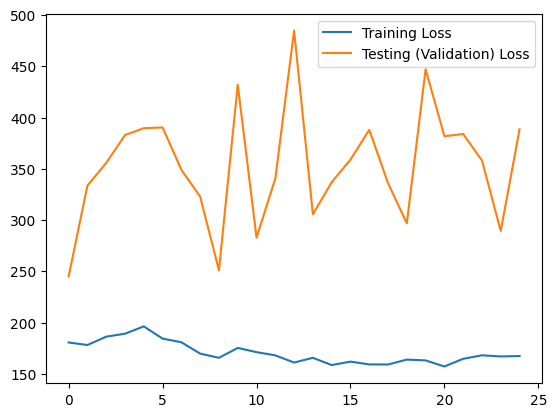

In [ ]:
plt.plot(range(0,num_epochs), total_loss.iloc[:,0], label='Training Loss')
plt.plot(range(0,num_epochs), total_loss.iloc[:,1], label='Testing (Validation) Loss')
plt.legend(loc='best')
plt.show()

**Plot Training vs Validation Accuracy**

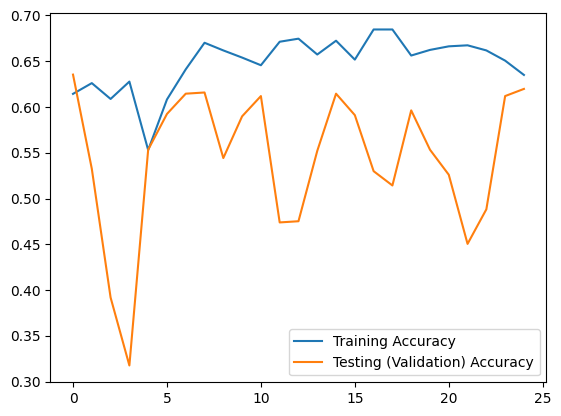

In [ ]:
plt.plot(range(0,num_epochs), total_accuracy.iloc[:,0], label='Training Accuracy')
plt.plot(range(0,num_epochs), total_accuracy.iloc[:,1], label='Testing (Validation) Accuracy')
plt.legend(loc='best')
plt.show()

**Plot Multiclass ROC Curve**

In [ ]:
# total_accuracy = pd.DataFrame(columns=["training accuracy", "testing (validation) accuracy"])
# total_loss = pd.DataFrame(columns=["training loss", "testing (validation) loss"])
# train_predictions = []
# train_labels = []
# test_predictions = []
# test_labels = []

In [ ]:
test_pred_labels = pd.DataFrame(columns=['prediction','true label'])

for i in range(len(test_predictions)):
  print(i)
  for j in range(len(test_predictions[0])):
    test_pred_labels.loc[len(test_pred_labels.index)] = [int(test_predictions[i][j]), int(test_labels[i][j])]

test_last_epoch = test_pred_labels.iloc[-batcheSize:].reset_index(drop=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


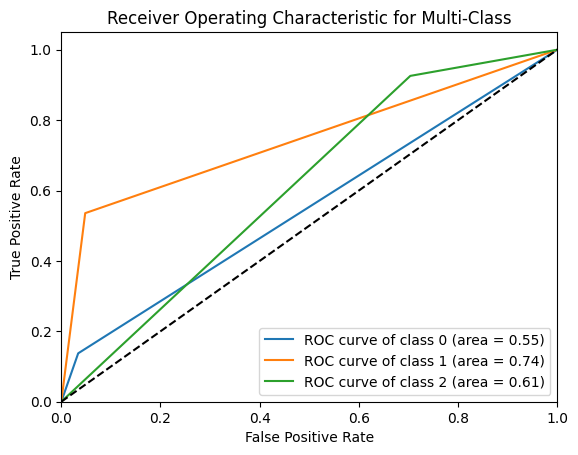

In [ ]:
def plot_multiclass_roc_curve(test_labels, predicted_labels, n_classes):
    # Binarize the labels
    test_labels_binarized = label_binarize(test_labels, classes=np.arange(n_classes))
    predicted_labels_binarized = label_binarize(predicted_labels, classes=np.arange(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Calculate ROC curve and ROC-AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], predicted_labels_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot the ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

plot_multiclass_roc_curve(test_last_epoch.iloc[:,1],test_last_epoch.iloc[:,0],3)

**Plot Confusion Matrix**

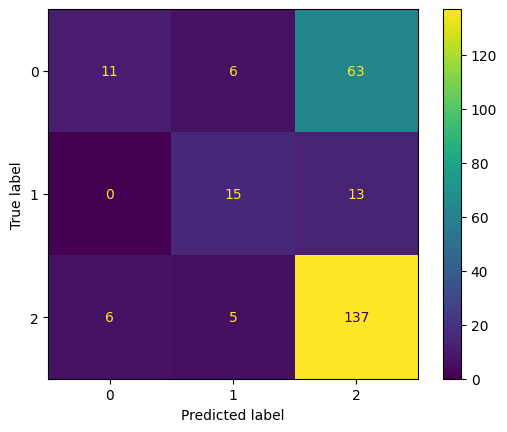

In [ ]:
def plot_confusion_matrix(test_labels, predicted_labels):
    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot()
    plt.show()

plot_confusion_matrix(test_last_epoch.iloc[:,1],test_last_epoch.iloc[:,0])

**Print Metrics**

In [ ]:
# compute the balanced accuracy score
balanced_accuracy = balanced_accuracy_score(test_last_epoch.iloc[:,1],test_last_epoch.iloc[:,0])
print("Balanced accuracy score:", balanced_accuracy)

Balanced accuracy score: 0.5329633204633205


In [ ]:
# get general metrics
print(classification_report(test_last_epoch.iloc[:,1],test_last_epoch.iloc[:,0]))

              precision    recall  f1-score   support

           0       0.65      0.14      0.23        80
           1       0.58      0.54      0.56        28
           2       0.64      0.93      0.76       148

    accuracy                           0.64       256
   macro avg       0.62      0.53      0.51       256
weighted avg       0.64      0.64      0.57       256

